# CEG5103 Wireless and Sensor Networks for IoT / EE5024 IoT Sensor Networks

(c) CK Tham, ECE NUS, 2023

In [1]:
# For Google Colab: can comment this out if file is already uploaded to Colab workspace
# Select and upload sensor_data.csv
#from google.colab import files   
#uploaded = files.upload()

In [2]:
# For Google Colab: can comment this out if file is already uploaded to Colab workspace
# Select and upload fail_log.csv
#from google.colab import files   
#uploaded = files.upload()

#Failure Prediction

This notebook will guide you through building and comparing classification models for failure prediction. 

In [3]:
# Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## 1 Exploring the data

Let us begin by loading and exploring the sensor data.

In [4]:
file_path = 'sensor_data.csv'
sen_data = pd.read_csv(file_path)
print(sen_data.dtypes)
sen_data.head()

datetime      object
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object


,datetime,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,151.919999,530.813578,101.788175,49.604013
1,2015-01-01 07:00:00,174.522001,535.523532,113.256009,41.515905
2,2015-01-01 08:00:00,146.912822,456.080746,107.786965,42.099694
3,2015-01-01 09:00:00,179.530561,503.469990,108.283817,37.847727
4,2015-01-01 10:00:00,180.544277,371.600611,107.553307,41.467880


The sensor data set consists of four different sensor measurements recorded at different time points. The `datetime` column needs to be converted to appropriate type.

In [5]:
print("-----BEFORE-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

# Date convert to timestamp data type
sen_data['datetime'] = pd.to_datetime(sen_data['datetime'])

print("-----AFTER-----")
print(sen_data['datetime'][0])
print(type(sen_data['datetime'][0]))

-----BEFORE-----
2015-01-01 06:00:00
<class 'str'>
-----AFTER-----
2015-01-01 06:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In addition, the failure log events are also available in `fail_log.csv`.

In [6]:
fail_dt = pd.read_csv('fail_log.csv')
fail_dt.head()

,datetime
0,2/4/2015 6:00
1,3/21/2015 6:00
2,4/5/2015 6:00
3,5/5/2015 6:00
4,5/20/2015 6:00


The data consists of only a single column

In [7]:
fail_dt['datetime'] = pd.to_datetime(fail_dt['datetime']) # Date convert to timestamp data type

## 2 Visualizing the data

Let us visualize the voltage measurement along with the failure events.

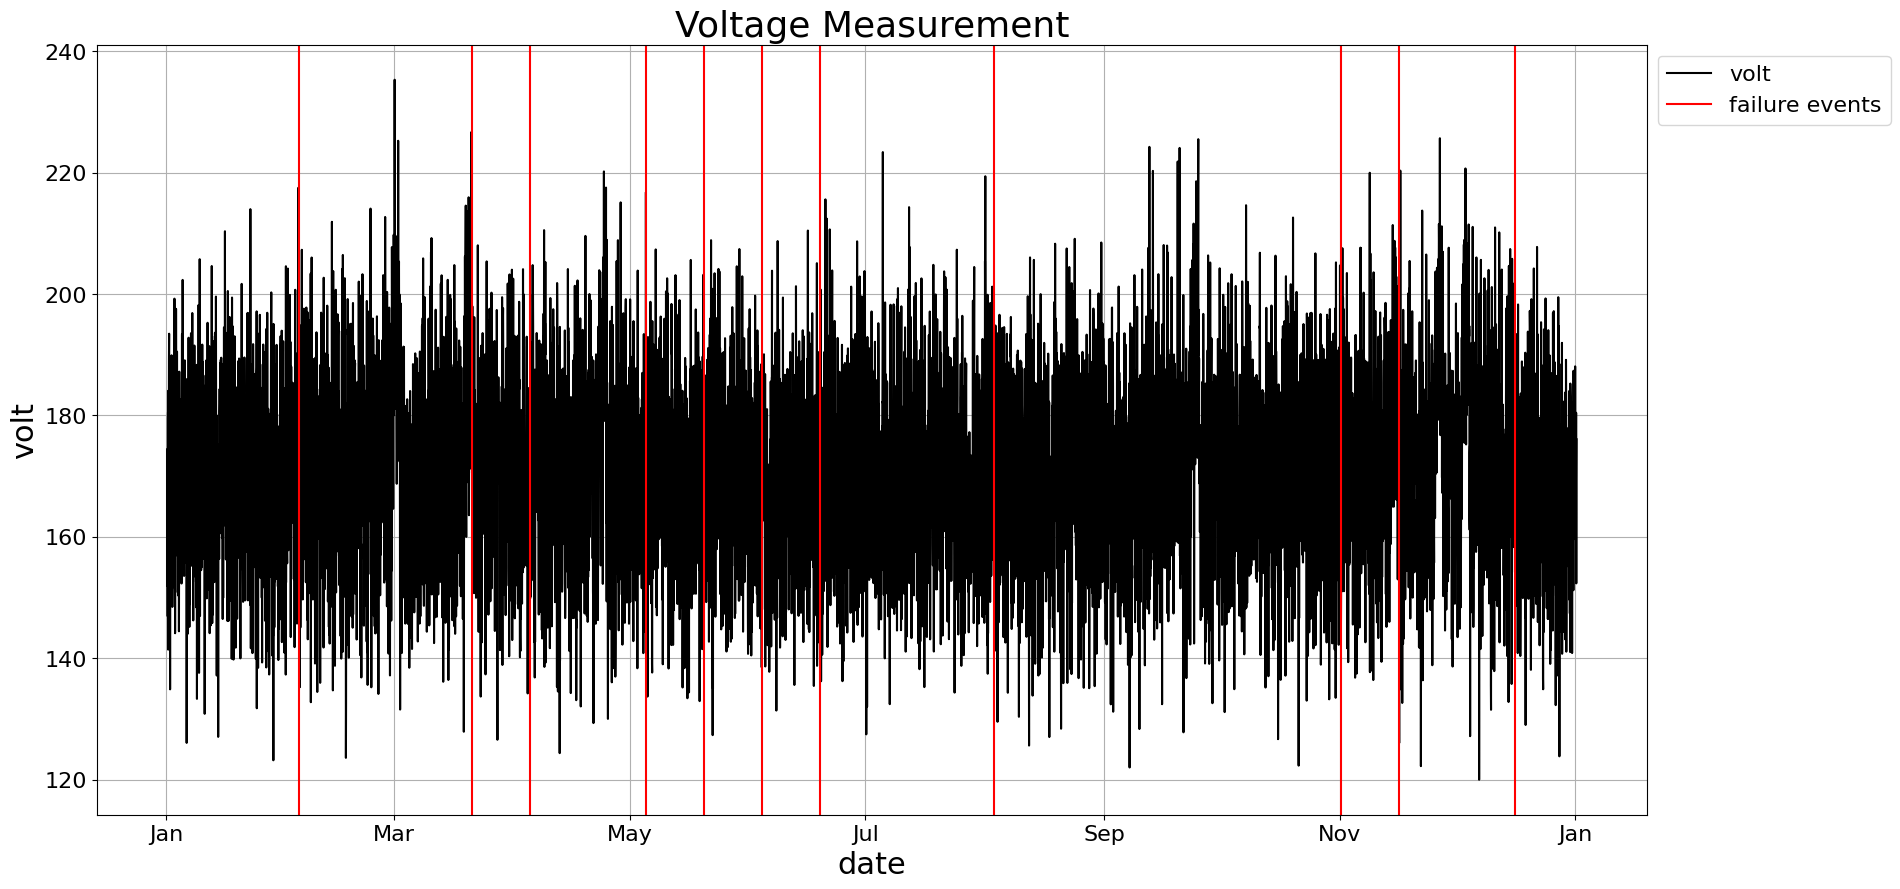

In [8]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(sen_data['datetime'], sen_data['volt'], color='black', label='volt')
ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
for dt in fail_dt['datetime'][1:]:
  ax.axvline(x=dt, color='red')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

The plot represents the sensor measurements and the failure time points (red line).

A function to plot sensors and failure events in a single plot will be helpful later on.

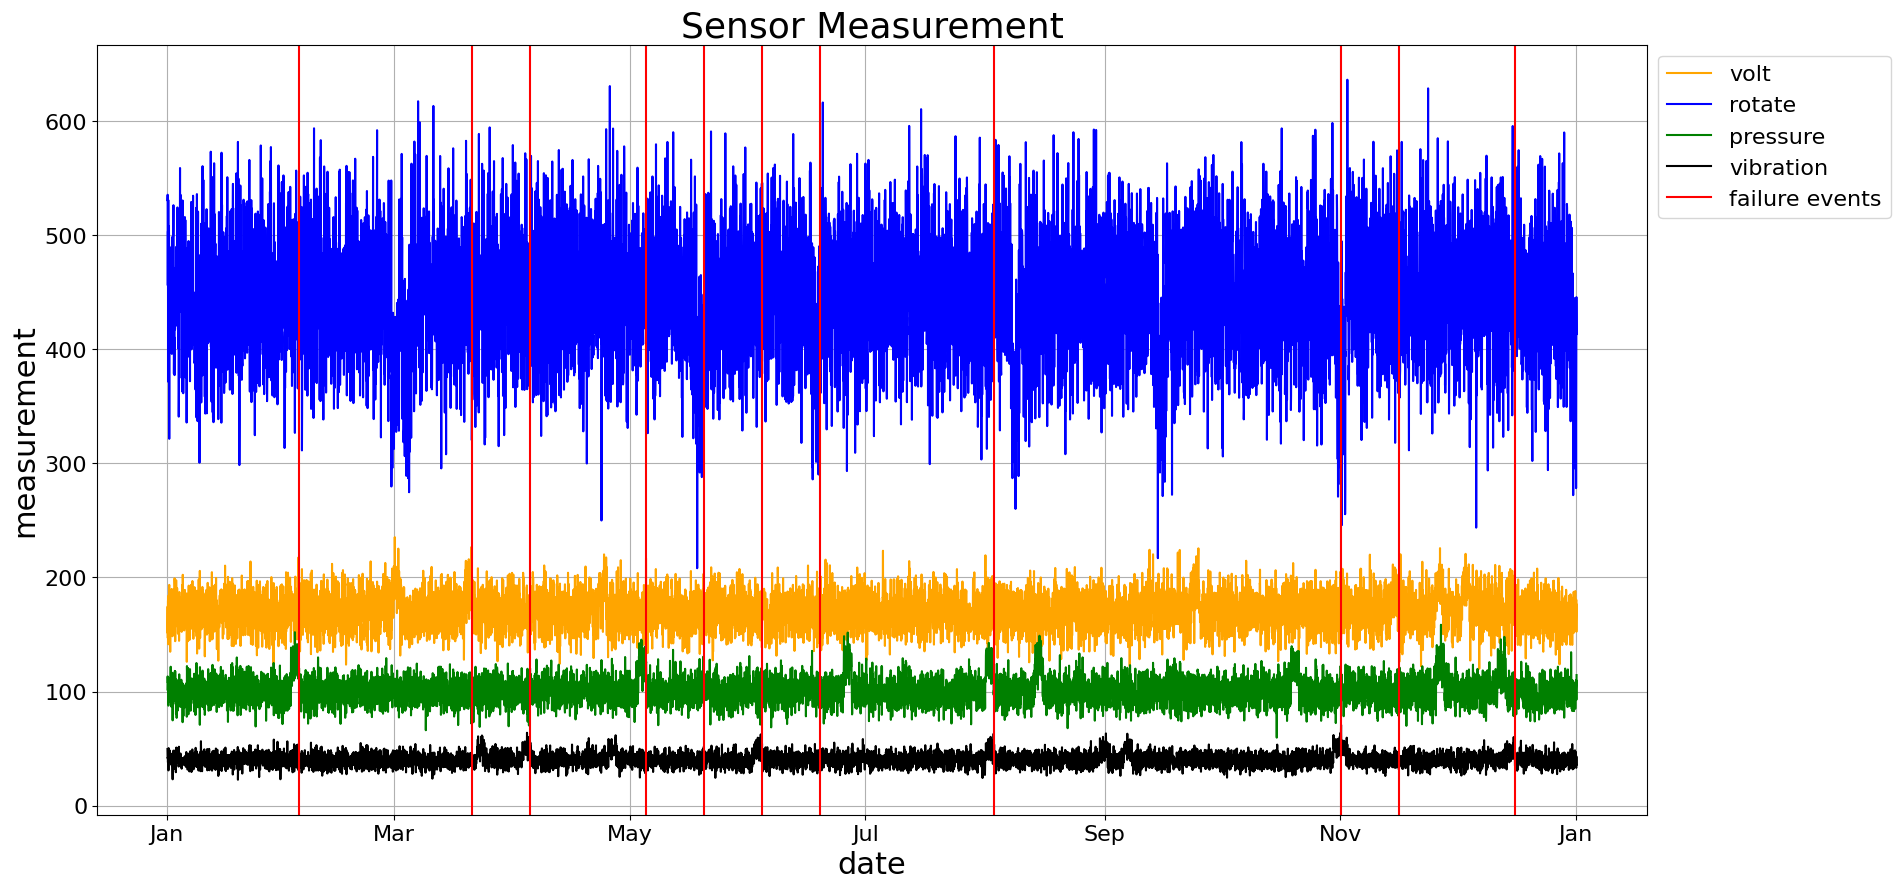

In [9]:
def plot_diagnostic_data(sen_data, fail_dt, predicted_fail_dt):
    fig, ax =  plt.subplots(figsize=(20,10))

    # Plot data
    ax.plot(sen_data['datetime'], sen_data['volt'], color='orange', label='volt')
    ax.plot(sen_data['datetime'], sen_data['rotate'], color='blue', label='rotate')
    ax.plot(sen_data['datetime'], sen_data['pressure'], color='green', label='pressure')
    ax.plot(sen_data['datetime'], sen_data['vibration'], color='black', label='vibration')

    ax.axvline(x=fail_dt['datetime'][0], color='red', label='failure events')
    for dt in fail_dt['datetime'][1:]:
        ax.axvline(x=dt, color='red')

    if type(predicted_fail_dt) != type(None):
        if predicted_fail_dt.empty != True:
            ax.axvline(x=predicted_fail_dt['datetime'][0], color='blue', label='predicted failure events', linestyle = '--')
            for dt in predicted_fail_dt['datetime'][1:]:
                ax.axvline(x=dt, color='blue', linestyle = '--')
        else: 
            print('\033[91m' + '\033[1m' + '-'*50 + 'EMPTY PREDICTED FAILURE DATA!' + '-'*50 + '\033[0m')

    # Format X axis - DateTime
    # date_form = DateFormatter("%m-%d")
    date_form = DateFormatter("%b")
    ax.xaxis.set_major_formatter(date_form)

    plt.title("Sensor Measurement", fontsize = 26)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("date", fontsize = 22)
    plt.ylabel("measurement", fontsize = 22)
    plt.grid()
    plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

    plt.show()

plot_diagnostic_data(sen_data, fail_dt, None)

## 3 Sliding window

Sensor measurements are often noisy! Features from a sliding window are used to capture a better trend of the underlying data. Consider the voltage measurements in the month of February

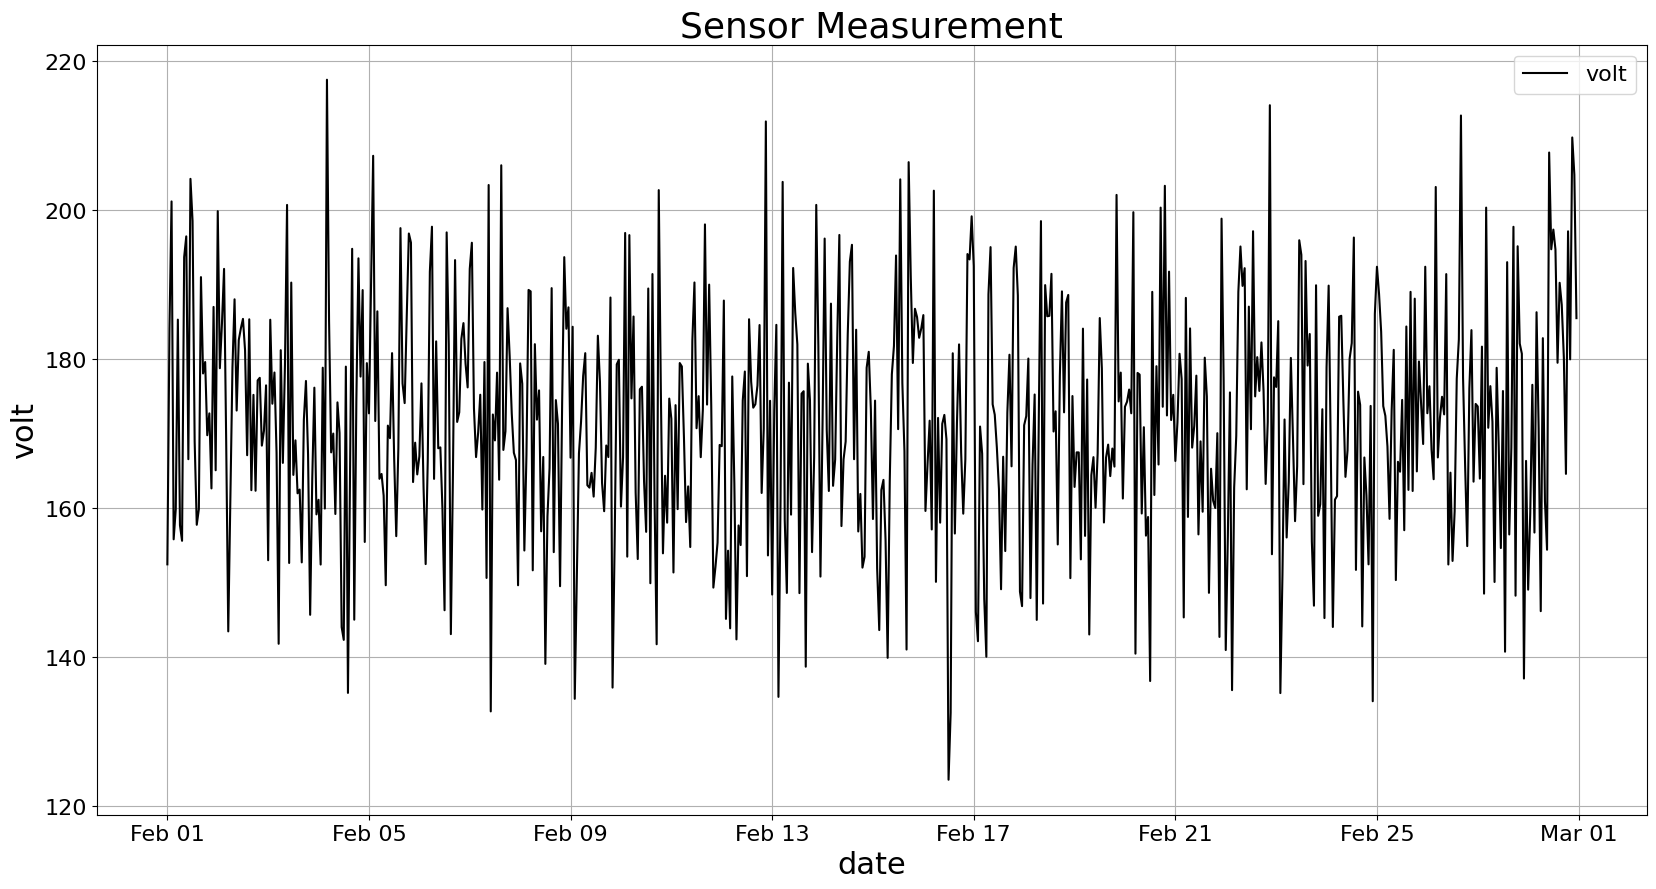

In [10]:
# Extract February data
data = sen_data[[True if data.strftime("%B") == 'February' else False for data in sen_data['datetime']]]
data = data.reset_index(drop=True)

fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(data['datetime'], data['volt'], color='black', label='volt')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)

plt.title("Sensor Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

Computing the rolling mean of 20 readings will give:

In [11]:
win_size = 20
data = data.sort_values(by='datetime', ascending = True) # Ensure time order is preserved
data['roll_volt'] = np.nan
for i in range(len(data)-20+1):
    data.at[i+win_size-1, 'roll_volt'] = data['volt'][i:i+win_size].mean()

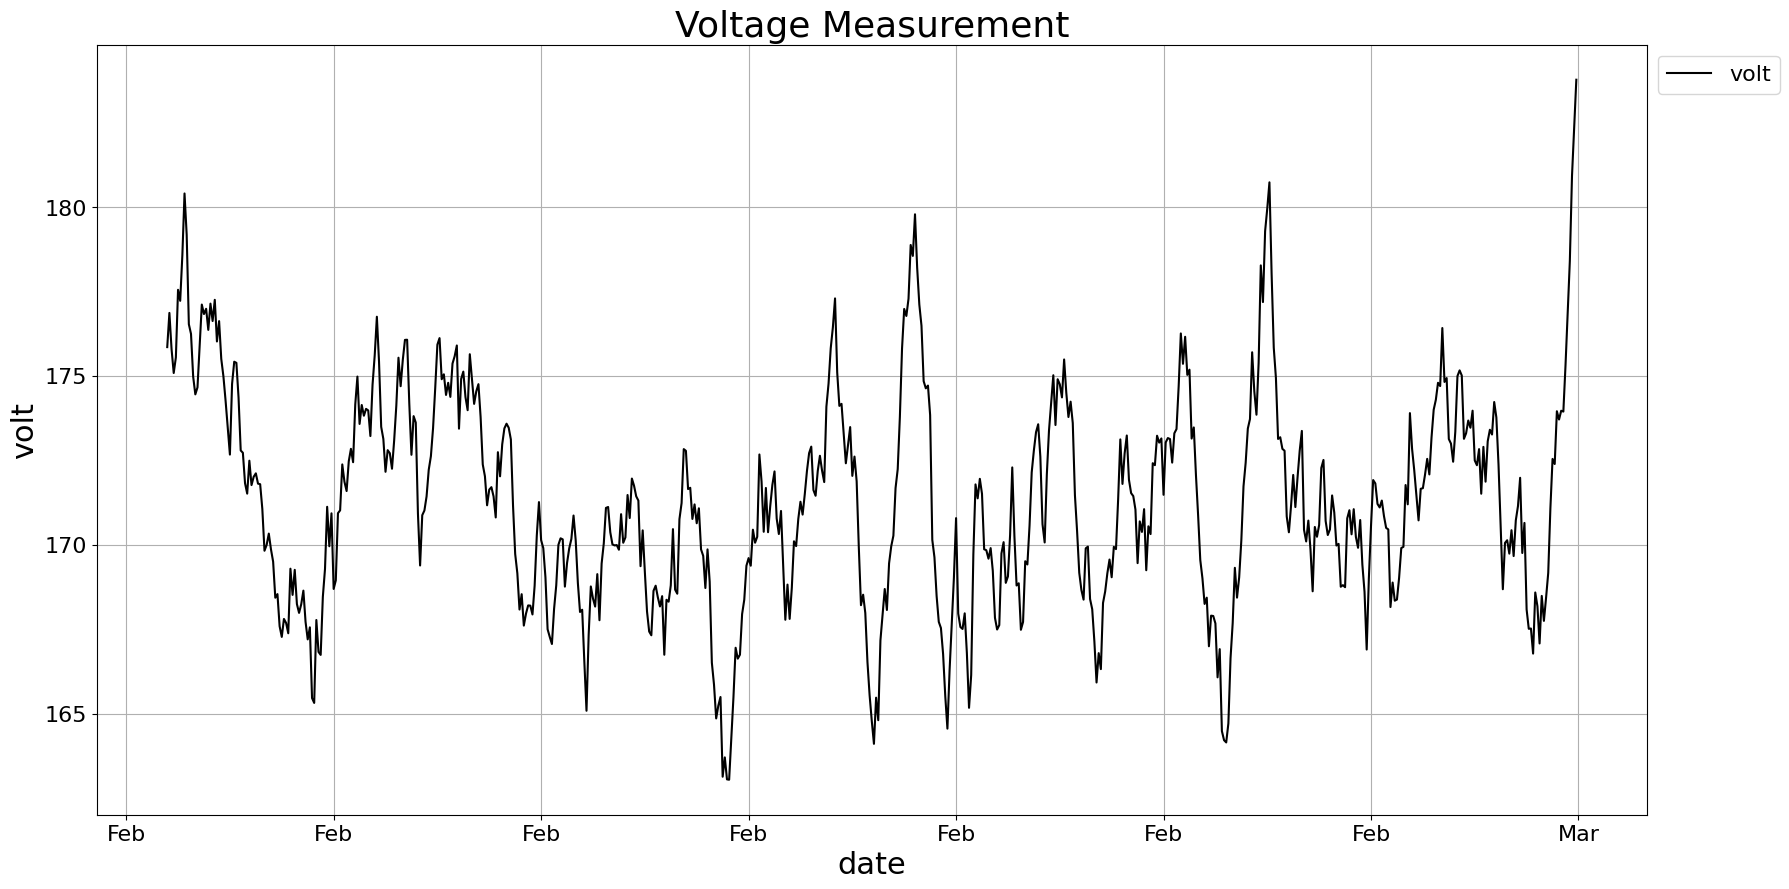

In [12]:
fig, ax =  plt.subplots(figsize=(20,10))

# Plot data
ax.plot(data['datetime'], data['roll_volt'], color='black', label='volt')

# Format X axis - DateTime
# date_form = DateFormatter("%m-%d")
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.title("Voltage Measurement", fontsize = 26)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("date", fontsize = 22)
plt.ylabel("volt", fontsize = 22)
plt.grid()
plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

plt.show()

Let us write a general purpose `function` that will compute sliding window `mean` for all the sensor columns.

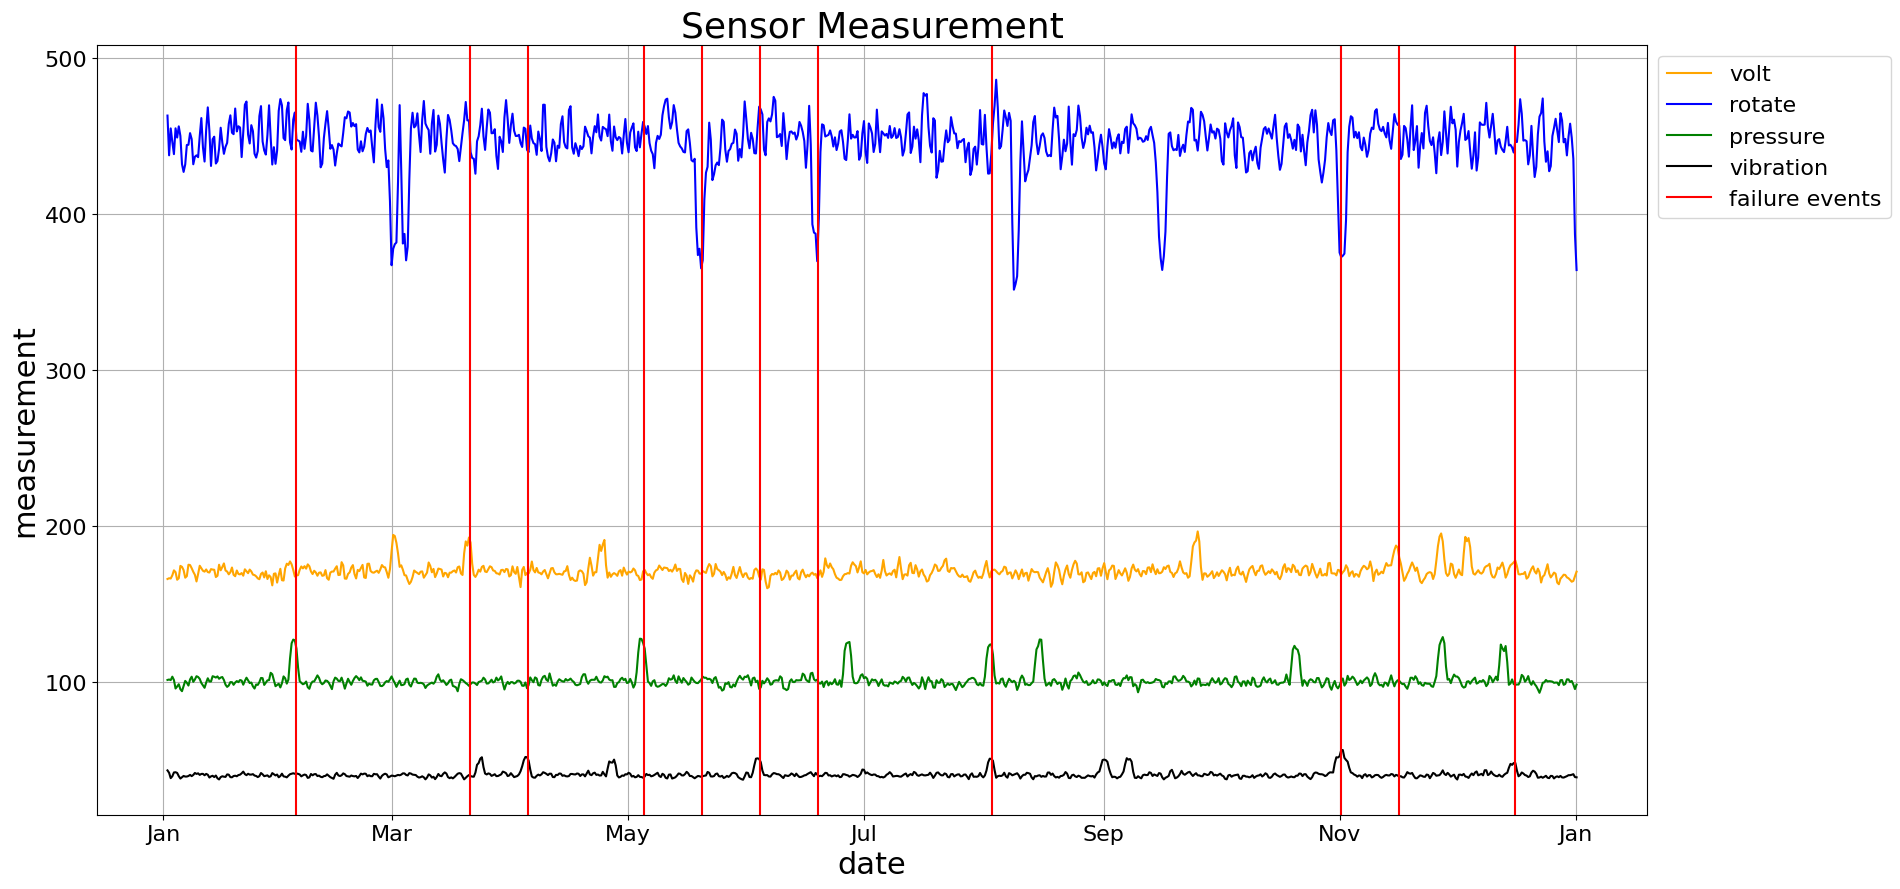

In [13]:
def sliding_mean(data, win_size, step_size=1):
    data_dict = {}
    for col_name in data.columns:
        data_dict[col_name] = []
    for col_name in data.columns:
        i = 0
        while i < (len(data)-win_size):
            if(col_name == 'datetime'):
                data_dict[col_name].append(data[col_name][i+win_size-1])
            else:   
                data_dict[col_name].append(data[col_name][i:i+win_size].mean())
            i += step_size
        
    return (pd.DataFrame(data_dict))

slide_mean_data = sliding_mean(sen_data, 20, 10)

plot_diagnostic_data(slide_mean_data, fail_dt, None)

## 4 Failure prediction

How can we predict failures in machines given sensor measurements? One way to do it is to use classification algorithms. Let us try one of them here.

### 4.1 Preparing the data
Before we embark on building classification models, let us separate the data into training and test sets.

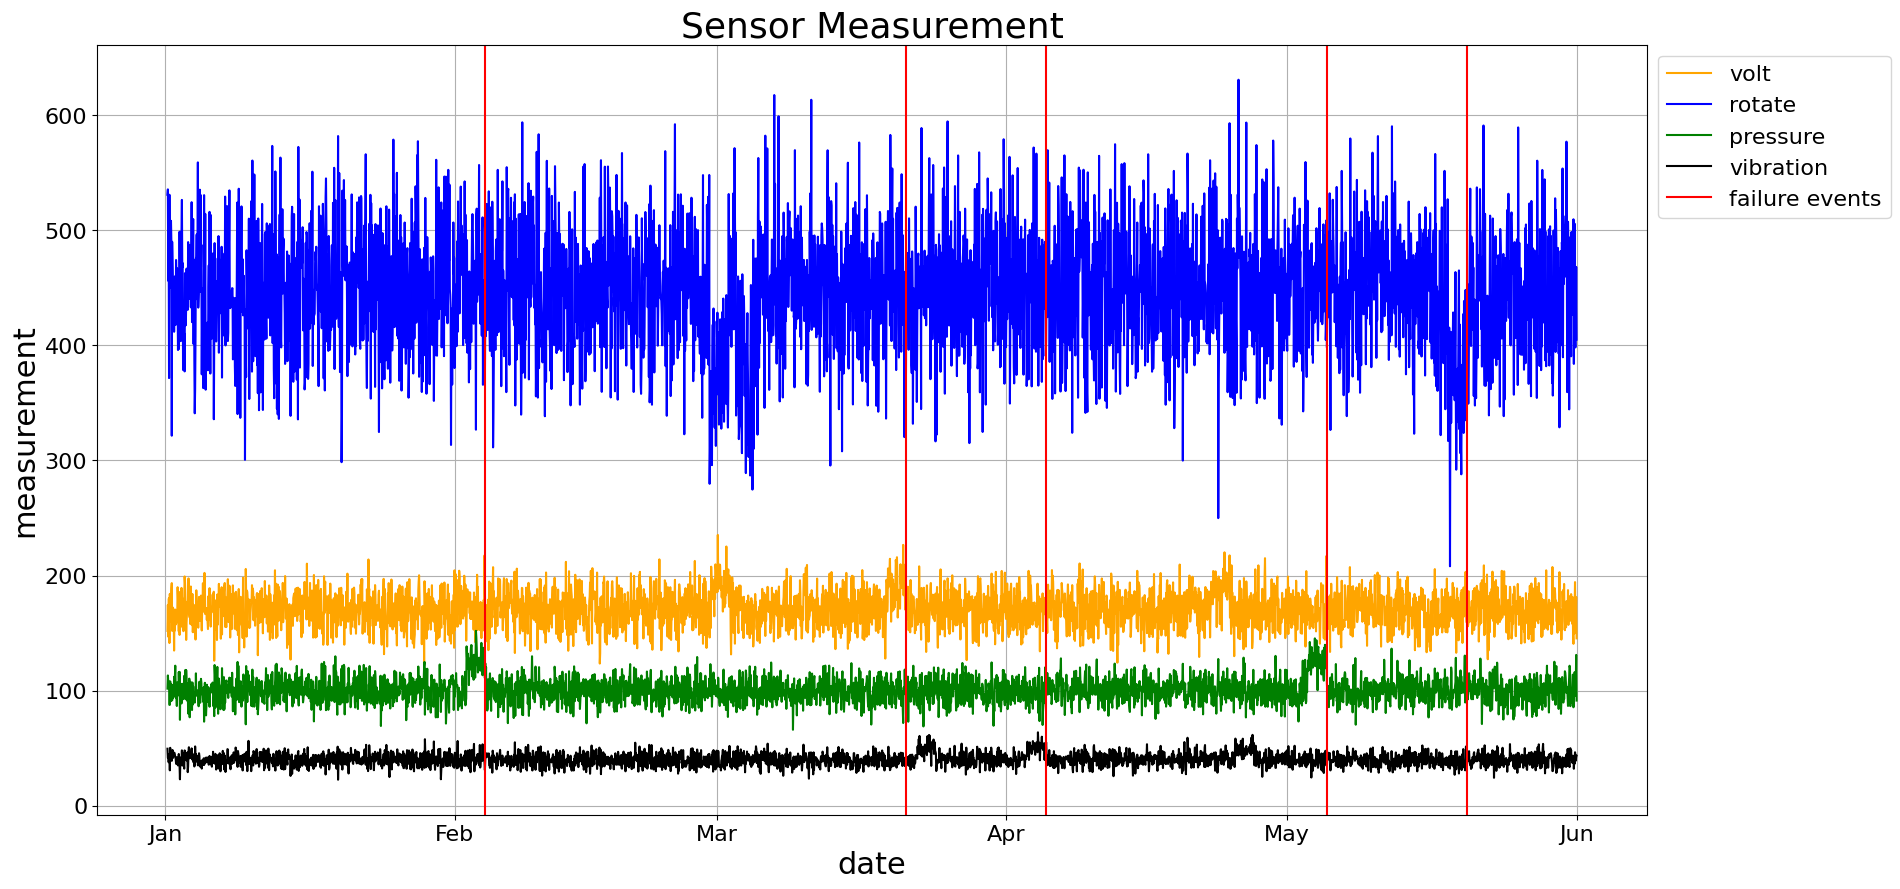

In [14]:
train_tp = pd.to_datetime("2015-06-01")
train_data = sen_data[sen_data['datetime'] <= train_tp]
train_data_fail = fail_dt[fail_dt['datetime'] <= train_tp]

plot_diagnostic_data(train_data, train_data_fail, None)

As discussed, lets use a sliding window to transform the data.

In [15]:
train_data = sliding_mean(train_data, 20, 10)

For classification, we need a training data set with inputs and outputs. Let us match the failure events as outputs.

In [16]:
train_data['state'] = 'normal'
for dt in train_data_fail['datetime']:
    for i in range(len(train_data)):
        # Find time point that was just before failure event
        if(dt < train_data['datetime'][i]):
            train_data.at[i-1, 'state'] = 'failure'
            break
            
train_data['state'].value_counts()

normal     355
failure      5
Name: state, dtype: int64

### 4.2  k Nearest Neighbour (kNN) Model

Let us build a kNN model for failure prediction.

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(train_data[train_data.columns.difference(['datetime', 'state'])], train_data['state'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Using the model, let us check the prediction for the whole data set.

In [18]:
all_data = sliding_mean(sen_data, 20, 10)
knn_predict = knn_model.predict(all_data[all_data.columns.difference(['datetime', 'state'])])
knn_fail_dt = all_data[knn_predict=='failure']['datetime'].to_frame().reset_index()
knn_fail_dt

,index,datetime
0,78,2015-02-03 13:00:00
1,79,2015-02-03 23:00:00
2,423,2015-06-27 07:00:00
3,792,2015-11-28 01:00:00


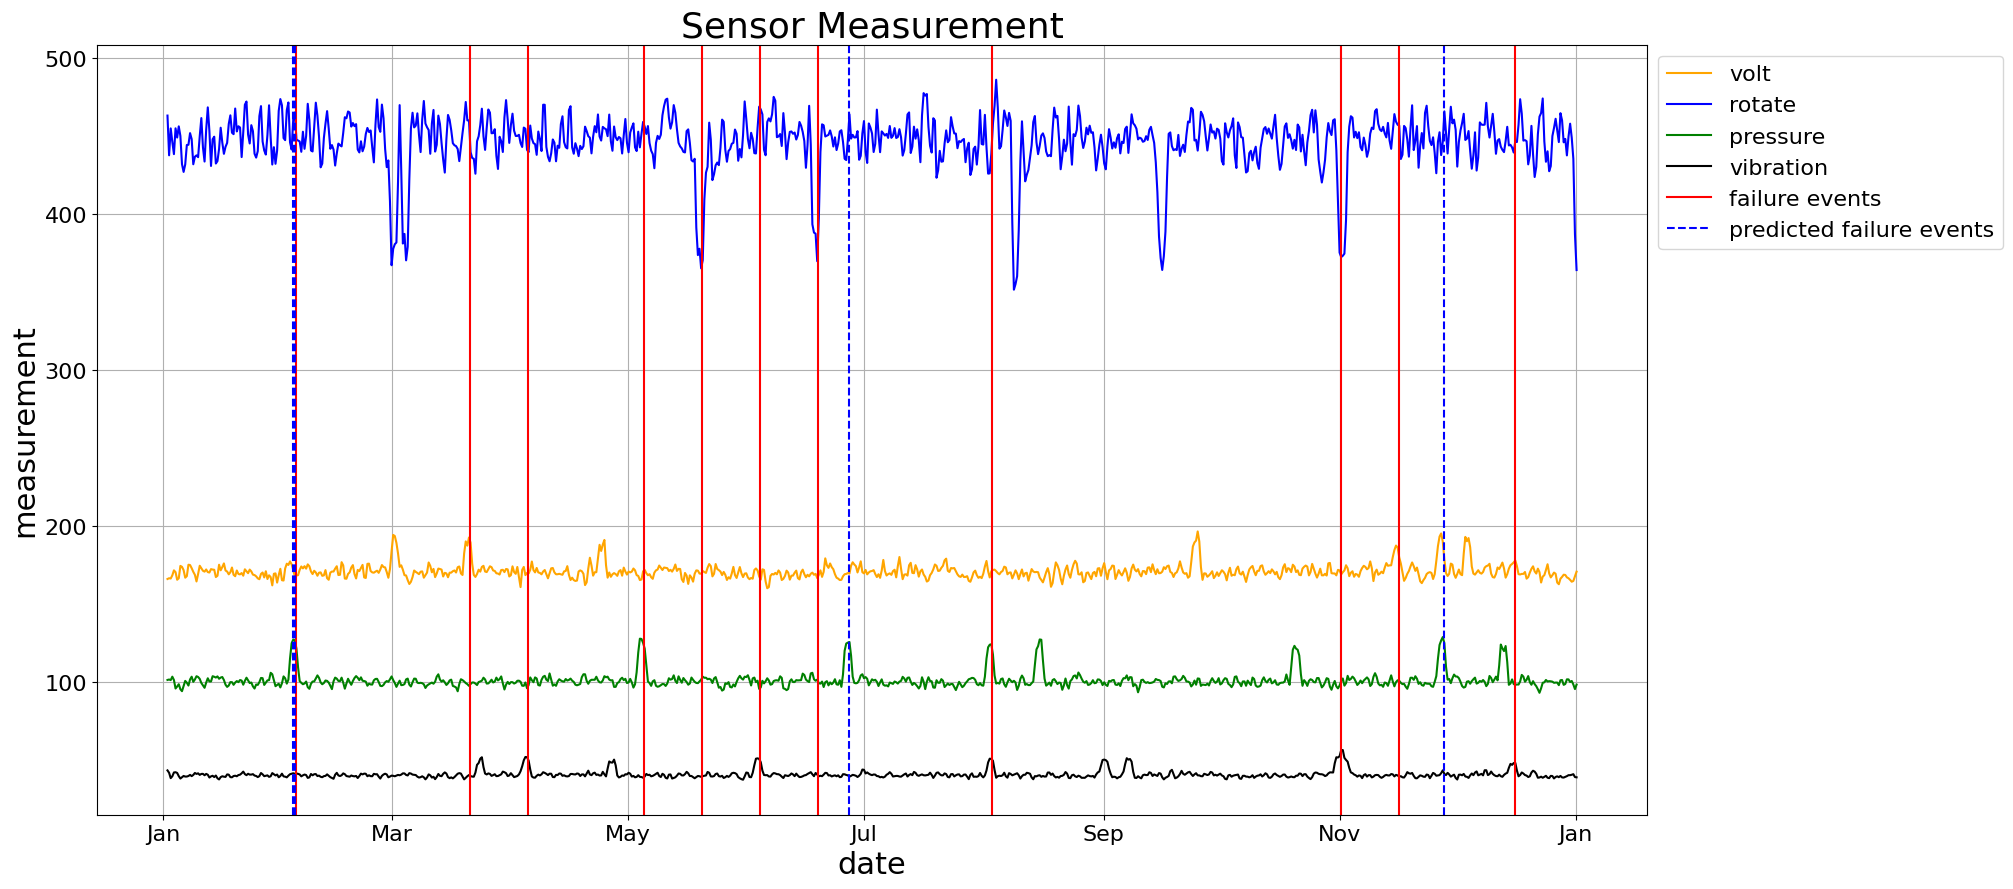

In [19]:
plot_diagnostic_data(all_data, fail_dt, knn_fail_dt)

kNN predicts only 4 failure events (blue dashed lines).

In [20]:
true_state = {'datetime' : all_data['datetime'],
              'state' : ['normal']*len(all_data)}
true_state = pd.DataFrame(true_state)
for dt in fail_dt['datetime']:
    for i in range(len(true_state)):
        # Find time point that was just before failure event
        if(dt < true_state['datetime'][i]):
            true_state.at[i-1, 'state'] = 'failure'
            break

true_state = np.array(true_state['state'])

The true states are compared to the predicted states to form the confusion matrix and compute other classification metrics such as accuracy and GMean score which is sqrt(recall*specificity).

In [21]:
def classification_metrics(predicted, true):
    cm = confusion_matrix(true, predicted, labels = ['failure', 'normal'])
    print("Confusion Matrix:")
    print("             Predicted")
    print("             failure normal")
    print("True failure       " + str(cm[0][0]) + "      " + str(cm[0][1]))
    print("      normal       " + str(cm[1][0]) + "     " + str(cm[1][1]))

    acc = accuracy_score(true, predicted)*100
    gm = np.sqrt(np.prod([cm.diagonal()/np.sum(cm, axis=1)]))*100
    print('\nWith accuracy of {0:.2f}% and GMean score of {1:.2f}%'.format(acc, gm))

# Write the code to compute Recall, Specificity, Precision and F-score in the function above
# Print out these results   

Evaluating for kNN model,

In [22]:
classification_metrics(knn_predict, true_state)

Confusion Matrix:
             Predicted
             failure normal
True failure       1      10
      normal       3     861

With accuracy of 98.51% and GMean score of 30.10%


### 5  Other Failure Prediction Method 1

Name and Student No.

Write the code for the proposed prediction method and fit or train the model.

You may change the window size and step size for the sliding mean, but all members in the same group must use the same values for these 2 parameters.

Use this method to predict failures for the entire duration in the dataset and evaluate its performance.

Show the diagnostic data graph with actual and predicted failures, and print out the six classification metrics.

In [23]:
# Write Code

### 6  Other Failure Prediction Method 2

Name and Student No.

Write the code for the proposed prediction method and fit or train the model.

You may change the window size and step size for the sliding mean, but all members in the same group must use the same values for these 2 parameters.

Use this method to predict failures for the entire duration in the dataset and evaluate its performance.

Show the diagnostic data graph with actual and predicted failures, and print out the six classification metrics.

In [24]:
# Write Code

### 7  Other Failure Prediction Method 3

Name and Student No.

Write the code for the proposed prediction method and fit or train the model.

You may change the window size and step size for the sliding mean, but all members in the same group must use the same values for these 2 parameters.

Use this method to predict failures for the entire duration in the dataset and evaluate its performance.

Show the diagnostic data graph with actual and predicted failures, and print out the six classification metrics.

In [25]:
# Write Code

### 8  Other Failure Prediction Method 4

Name and Student No.

Write the code for the proposed prediction method and fit or train the model.

You may change the window size and step size for the sliding mean, but all members in the same group must use the same values for these 2 parameters.

Use this method to predict failures for the entire duration in the dataset and evaluate its performance.

Show the diagnostic data graph with actual and predicted failures, and print out the six classification metrics.

In [26]:
# Write Code

### 9  Other Failure Prediction Method 5

Name and Student No.

Write the code for the proposed prediction method and fit or train the model.

You may change the window size and step size for the sliding mean, but all members in the same group must use the same values for these 2 parameters.

Use this method to predict failures for the entire duration in the dataset and evaluate its performance.

Show the diagnostic data graph with actual and predicted failures, and print out the six classification metrics.

In [27]:
# Write Code

### Tabulation of Results

Tabulate the 6 classification metrics (Accuracy, GMean, Recall, Specificity, Precision and F-score) in the form of a number between 0 and 1, with 3 decimal points, for all the failure prediction methods studied by the group.

The different methods should be shown as rows of the table in the order presented above, and the 6 classification metrics should be shown as columns of the table in the order shown above.

In [28]:
# Write Code

In [29]:
import numpy as np
from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

rng = np.random.RandomState(42)


def preprocess_dataset(dataset_name):

    # loading and vectorization
    print(f"Loading {dataset_name} data")
    if dataset_name in ["http", "smtp", "SA", "SF"]:
        dataset = fetch_kddcup99(subset=dataset_name, percent10=True, random_state=rng)
        X = dataset.data
        y = dataset.target
        lb = LabelBinarizer()

        if dataset_name == "SF":
            idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
            X = X[idx]  # reduce the sample size
            y = y[idx]
            x1 = lb.fit_transform(X[:, 1].astype(str))
            X = np.c_[X[:, :1], x1, X[:, 2:]]
        elif dataset_name == "SA":
            idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
            X = X[idx]  # reduce the sample size
            y = y[idx]
            x1 = lb.fit_transform(X[:, 1].astype(str))
            x2 = lb.fit_transform(X[:, 2].astype(str))
            x3 = lb.fit_transform(X[:, 3].astype(str))
            X = np.c_[X[:, :1], x1, x2, x3, X[:, 4:]]
        y = (y != b"normal.").astype(int)
    if dataset_name == "forestcover":
        dataset = fetch_covtype()
        X = dataset.data
        y = dataset.target
        idx = rng.choice(X.shape[0], int(X.shape[0] * 0.1), replace=False)
        X = X[idx]  # reduce the sample size
        y = y[idx]

        # inliers are those with attribute 2
        # outliers are those with attribute 4
        s = (y == 2) + (y == 4)
        X = X[s, :]
        y = y[s]
        y = (y != 2).astype(int)
    if dataset_name in ["glass", "wdbc", "cardiotocography"]:
        dataset = fetch_openml(
            name=dataset_name, version=1, as_frame=False, parser="pandas"
        )
        X = dataset.data
        y = dataset.target

        if dataset_name == "glass":
            s = y == "tableware"
            y = s.astype(int)
        if dataset_name == "wdbc":
            s = y == "2"
            y = s.astype(int)
            X_mal, y_mal = X[s], y[s]
            X_ben, y_ben = X[~s], y[~s]

            # downsampled to 39 points (9.8% outliers)
            idx = rng.choice(y_mal.shape[0], 39, replace=False)
            X_mal2 = X_mal[idx]
            y_mal2 = y_mal[idx]
            X = np.concatenate((X_ben, X_mal2), axis=0)
            y = np.concatenate((y_ben, y_mal2), axis=0)
        if dataset_name == "cardiotocography":
            s = y == "3"
            y = s.astype(int)
    # 0 represents inliers, and 1 represents outliers
    y = pd.Series(y, dtype="category")
    return (X, y)

In [30]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest


def compute_prediction(X, model_name):

    print(f"Computing {model_name} prediction...")
    if model_name == "LOF":
        clf = LocalOutlierFactor(n_neighbors=20, contamination="auto")
        clf.fit(X)
        y_pred = clf.negative_outlier_factor_
    if model_name == "IForest":
        clf = IsolationForest(random_state=rng, contamination="auto")
        y_pred = clf.fit(X).decision_function(X)
    return y_pred

Loading http data


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1051)>

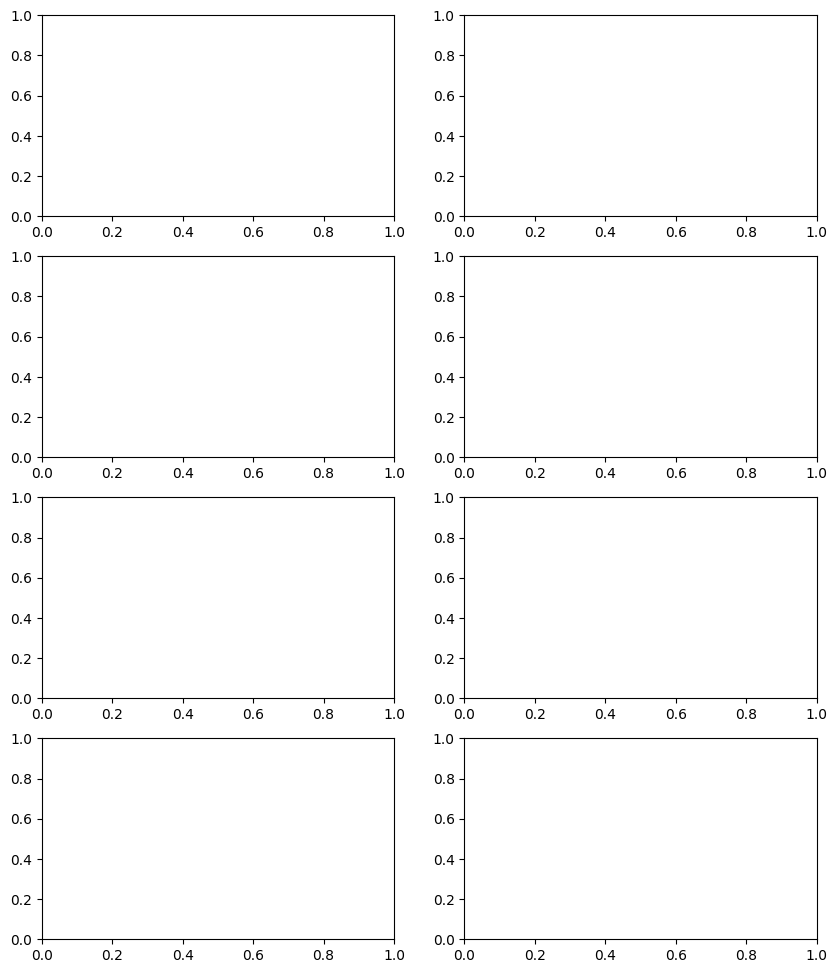

In [33]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

datasets_name = [
    "http",
    "smtp",
    "SA",
    "SF",
    "forestcover",
    "glass",
    "wdbc",
    "cardiotocography",
]

models_name = [
    "LOF",
    "IForest",
]

# plotting parameters
cols = 2
linewidth = 1
pos_label = 0  # mean 0 belongs to positive class
rows = math.ceil(len(datasets_name) / cols)

fig, axs = plt.subplots(rows, cols, figsize=(10, rows * 3))

for i, dataset_name in enumerate(datasets_name):
    (X, y) = preprocess_dataset(dataset_name=dataset_name)

    for model_name in models_name:
        y_pred = compute_prediction(X, model_name=model_name)
        display = RocCurveDisplay.from_predictions(
            y,
            y_pred,
            pos_label=pos_label,
            name=model_name,
            linewidth=linewidth,
            ax=axs[i // cols, i % cols],
        )
    axs[i // cols, i % cols].plot([0, 1], [0, 1], linewidth=linewidth, linestyle=":")
    axs[i // cols, i % cols].set_title(dataset_name)
    axs[i // cols, i % cols].set_xlabel("False Positive Rate")
    axs[i // cols, i % cols].set_ylabel("True Positive Rate")
plt.tight_layout(pad=2.0)  # spacing between subplots
plt.show()